In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

import sys
sys.path.append('/Users/perdue/Documents/MINERvA/AI/ANNMINERvA/')

from evtid_utils import decode_eventid
from mnvtf.reader_sqlite import MnvCategoricalSQLiteReader
from mnvtf.reader_text import MnvCategoricalTextReader

from mnvdlplot.conf_mat_pl import make_conf_mat_plots_rowcolnormonly
from mnvdlplot.conf_mat_pl import make_conf_mat_plots_raw

In [18]:
from mnvtf.utils import encode_eventid

In [2]:
PLAYLIST = 'me1Amc'
PROCESSING = '201801'

In [3]:
h5path = '/Users/perdue/Documents/MINERvA/AI/hdf5/{}/'.format(PROCESSING)
h5name = h5path + 'hadmultkineimgs_127x94_{}.hdf5'.format(PLAYLIST)
h5file = h5py.File(h5name, 'r')

In [4]:
dbpath = '/Users/perdue/Documents/MINERvA/AI/prediction_dbs/tensorflow/{}/'.format(PROCESSING)
dbname_natural = dbpath + 'mnv_st_epsilon_predictionsME1AMCNX_model_20180223_def_chngdpad_planecodes_nclass173_trainME1EMC_validME1EMC_testME1EMC_optADAM_batchsz1024_nodoBatchNorm_tev.txt.gz'
dbname_missing = dbpath + 'mnv_st_epsilon_predictionsME1AMC_MISSINGFILESNX_model_20180223_def_chngdpad_planecodes_nclass173_trainME1EMC_validME1EMC_testME1EMC_optADAM_batchsz1024_nodoBatchNorm_tev.txt.gz'
dbname_targbal = dbpath + 'mnv_st_epsilon_predictionsME1AMCNX_model_20180226_def_chngdpad_planecodes_nclass173_trainME1EMC_TARGETS_BAL_validME1EMC_TARGETS_BAL_testME1EMC_TARGETS_BAL_optADAM_batchsz1024_nodoBatchNorm_tev.txt.gz'

In [5]:
n_classes = 173
reader_natural = MnvCategoricalTextReader(dbname_natural)
reader_targbal = MnvCategoricalTextReader(dbname_targbal)

In [6]:
mcgen_natural = reader_natural.read_data_generator()
mcgen_targbal = reader_targbal.read_data_generator()

In [7]:
prob_names = ['pcode{}'.format(i) for i in range(173)]
col_names = ['run', 'subrun', 'gate', 'phys_evt', 'planecode'] + prob_names

In [8]:
df_natural = pd.read_csv(dbname_natural, names=col_names)

In [9]:
df_natural.head()

,run,subrun,gate,phys_evt,planecode,pcode0,pcode1,pcode2,pcode3,pcode4,...,pcode163,pcode164,pcode165,pcode166,pcode167,pcode168,pcode169,pcode170,pcode171,pcode172
0,110006,105,625,2,135,1.731900e-08,1.949470e-11,4.783020e-12,1.553020e-12,7.407490e-12,...,9.147930e-09,5.152210e-08,3.014600e-08,8.675290e-09,6.726100e-09,1.115700e-09,4.259310e-10,4.283370e-10,2.094560e-09,1.250690e-08
1,110006,105,626,1,9,1.598690e-05,2.839400e-07,4.192600e-07,7.796760e-07,6.954370e-06,...,8.785310e-09,2.725780e-08,3.001240e-09,3.015860e-09,8.395480e-09,4.522960e-09,8.709330e-10,2.797870e-09,4.102320e-09,1.179770e-08
2,110006,105,631,1,27,4.744770e-05,2.244640e-06,3.597050e-06,3.345990e-07,2.664760e-07,...,1.206490e-08,5.857360e-10,2.928740e-08,3.080310e-09,7.492860e-10,6.107220e-08,3.346480e-08,2.128470e-08,3.019530e-07,2.304920e-07
3,110006,105,632,1,70,3.221050e-06,3.405290e-07,9.974650e-07,9.275130e-08,9.798070e-08,...,8.269330e-07,3.060330e-06,4.144240e-07,1.266280e-06,1.746920e-06,8.939730e-08,1.394050e-07,3.374520e-07,1.241810e-07,3.376550e-07
4,110006,105,641,2,143,6.694800e-05,9.289960e-06,8.481660e-06,6.511360e-06,1.006460e-05,...,1.308520e-05,5.808140e-06,1.274120e-05,1.031080e-05,4.712450e-05,5.538510e-05,1.649710e-05,1.986590e-06,3.851120e-06,2.557220e-06


In [10]:
df_natural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765828 entries, 0 to 1765827
Columns: 178 entries, run to pcode172
dtypes: float64(173), int64(5)
memory usage: 2.3 GB


In [11]:
dtypes = [df_natural[c].dtype for c in col_names]
print(dtypes)

[dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'), d

In [12]:
df_targbal = pd.read_csv(dbname_targbal, names=col_names)

In [13]:
df_targbal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1765828 entries, 0 to 1765827
Columns: 178 entries, run to pcode172
dtypes: float64(173), int64(5)
memory usage: 2.3 GB


In [14]:
nrec = h5file['event_data/eventids'][:].shape[0]
print(nrec)

1765828


In [31]:
d = {
    'eventids': list(np.reshape(h5file['event_data/eventids'][:], nrec)),
    'Q2': list(np.reshape(h5file['gen_data/Q2'][:], nrec)),
    'W': list(np.reshape(h5file['gen_data/W'][:], nrec)),
    'x': list(np.reshape(h5file['gen_data/x'][:], nrec)),
    'y': list(np.reshape(h5file['gen_data/y'][:], nrec)),
    'true_plane': list(np.reshape(h5file['vtx_data/planecodes'][:], nrec)),
}

In [32]:
df = pd.DataFrame(data=d)

In [33]:
df.head()

,Q2,W,eventids,true_plane,x,y
0,3.060432e+06,2.579643e+03,1100000001000202,18,0.345383,0.278034
1,2.984092e+05,1.226673e+03,1100000001001001,95,0.299016,0.093756
2,5.964411e+05,1.178164e+03,1100000001001501,44,0.516082,0.095757
3,1.106649e+06,2.651544e+03,1100000001001701,157,0.151142,0.656177
4,4.550963e+04,9.999900e+07,1100000001002004,98,-99999.000000,0.081627


In [19]:
evtids_natural = np.zeros(nrec, dtype=np.uint64)
evtids_targbal = np.zeros(nrec, dtype=np.uint64)

In [20]:
counter = 0
for x in zip(df_natural['run'][:], df_natural['subrun'][:], df_natural['gate'][:], df_natural['phys_evt'][:]):
    evtids_natural[counter] = int(encode_eventid(*x))
    counter += 1

In [21]:
counter = 0
for x in zip(df_targbal['run'][:], df_targbal['subrun'][:], df_targbal['gate'][:], df_targbal['phys_evt'][:]):
    evtids_targbal[counter] = int(encode_eventid(*x))
    counter += 1

In [22]:
df_natural['eventids'] = evtids_natural
df_targbal['eventids'] = evtids_targbal

In [24]:
df_natural.sort_values(by=['eventids'], inplace=True)
df_targbal.sort_values(by=['eventids'], inplace=True)

In [39]:
df_natural.head()

,run,subrun,gate,phys_evt,planecode,pcode0,pcode1,pcode2,pcode3,pcode4,...,pcode164,pcode165,pcode166,pcode167,pcode168,pcode169,pcode170,pcode171,pcode172,eventids
1477279,110000,1,2,2,18,1.861300e-06,4.472780e-08,1.287810e-07,4.863250e-08,1.247020e-07,...,4.524720e-09,2.173490e-09,4.459660e-09,1.469140e-09,1.868860e-09,8.243430e-09,7.243330e-09,1.683800e-09,2.196240e-09,1100000001000202
1477280,110000,1,10,1,96,1.669770e-11,3.940860e-10,9.457840e-10,2.991670e-10,2.047750e-09,...,2.447560e-13,2.356380e-12,1.419730e-11,1.927160e-11,6.846830e-11,1.693930e-11,4.716320e-12,4.061310e-10,5.869770e-12,1100000001001001
1477281,110000,1,15,1,44,1.941860e-07,6.044090e-08,1.220140e-07,4.036490e-08,3.596550e-08,...,1.293470e-09,6.465920e-10,5.989720e-11,2.664920e-10,1.719150e-10,4.899460e-12,1.028220e-10,7.475660e-09,3.875390e-09,1100000001001501
1477282,110000,1,17,1,157,1.210680e-08,2.151480e-11,8.141460e-11,1.349960e-10,3.740440e-10,...,1.896760e-07,1.777500e-07,2.004530e-08,1.146820e-08,3.039330e-09,1.090430e-08,3.551900e-09,5.799410e-09,8.905710e-11,1100000001001701
1477283,110000,1,20,4,99,3.449850e-12,2.145730e-12,1.421180e-12,5.641460e-14,4.448690e-13,...,2.171970e-11,1.471830e-12,2.366750e-11,9.832520e-12,1.419340e-11,1.435450e-11,1.894010e-12,2.111260e-11,4.029260e-11,1100000001002004


In [40]:
df_targbal.head()

,run,subrun,gate,phys_evt,planecode,pcode0,pcode1,pcode2,pcode3,pcode4,...,pcode164,pcode165,pcode166,pcode167,pcode168,pcode169,pcode170,pcode171,pcode172,eventids
1710028,110000,1,2,2,18,7.589710e-05,1.133740e-05,3.263150e-06,5.958950e-06,2.220850e-06,...,2.256040e-06,2.532200e-06,2.627120e-06,3.773360e-07,1.094060e-06,2.388140e-07,8.642590e-08,1.378880e-06,6.462730e-06,1100000001000202
1710029,110000,1,10,1,96,4.704170e-12,6.942040e-12,5.443010e-12,1.529070e-11,4.130900e-11,...,8.182300e-15,6.324230e-13,1.521230e-11,7.580690e-12,1.708350e-12,2.737510e-12,5.036170e-13,6.579960e-13,1.277020e-12,1100000001001001
1710030,110000,1,15,1,44,1.666880e-05,4.208280e-06,4.181850e-06,6.400770e-06,4.391240e-06,...,2.044390e-08,2.799280e-08,1.873380e-06,6.134420e-06,1.754060e-07,8.004450e-08,1.079980e-07,7.509640e-09,1.914940e-08,1100000001001501
1710031,110000,1,17,1,157,4.538760e-08,8.871230e-10,6.816600e-11,2.100250e-11,3.435240e-12,...,9.310440e-09,1.195800e-08,4.540200e-09,1.324720e-09,7.493310e-10,7.073070e-10,2.946890e-09,1.393490e-08,3.309040e-09,1100000001001701
1710032,110000,1,20,4,99,1.930320e-09,3.426730e-09,8.179240e-10,6.381160e-10,6.121670e-10,...,5.360070e-07,4.268110e-08,1.065560e-08,2.472070e-08,2.079890e-07,5.005340e-08,5.777710e-10,8.740070e-10,5.104170e-10,1100000001002004


In [41]:
n_evt = 10
for x in zip(df_natural['eventids'][:n_evt], df_targbal['eventids'][:n_evt], df['eventids'][:]):
    print(*x)

1100000001000202 1100000001000202 1100000001000202
1100000001001001 1100000001001001 1100000001001001
1100000001001501 1100000001001501 1100000001001501
1100000001001701 1100000001001701 1100000001001701
1100000001002004 1100000001002004 1100000001002004
1100000001002202 1100000001002202 1100000001002202
1100000001004401 1100000001004401 1100000001004401
1100000001005101 1100000001005101 1100000001005101
1100000001006401 1100000001006401 1100000001006401
1100000001007302 1100000001007302 1100000001007302


In [42]:
n_evt = 10
for x in zip(df_natural['eventids'][-n_evt:], df_targbal['eventids'][-n_evt:], df['eventids'][-n_evt:]):
    print(*x)

1100200500103501 1100200500103501 1100200500103501
1100200500104901 1100200500104901 1100200500104901
1100200500106402 1100200500106402 1100200500106402
1100200500106502 1100200500106502 1100200500106502
1100200500107201 1100200500107201 1100200500107201
1100200500108001 1100200500108001 1100200500108001
1100200500108601 1100200500108601 1100200500108601
1100200500108901 1100200500108901 1100200500108901
1100200500109001 1100200500109001 1100200500109001
1100200500109501 1100200500109501 1100200500109501


In [58]:
natural_planecodes = df_natural['planecode'].reset_index()
print(natural_planecodes['planecode'][:5])
targbal_planecodes = df_targbal['planecode'].reset_index()
print(targbal_planecodes['planecode'][:5])
df['planecode_natural'] = natural_planecodes['planecode']
df['planecode_targbal'] = targbal_planecodes['planecode']

0     18
1     96
2     44
3    157
4     99
Name: planecode, dtype: int64
0     18
1     96
2     44
3    157
4     99
Name: planecode, dtype: int64


In [59]:
df.head()

,Q2,W,eventids,true_plane,x,y,planecode_natural,planecode_targbal
0,3.060432e+06,2.579643e+03,1100000001000202,18,0.345383,0.278034,18,18
1,2.984092e+05,1.226673e+03,1100000001001001,95,0.299016,0.093756,96,96
2,5.964411e+05,1.178164e+03,1100000001001501,44,0.516082,0.095757,44,44
3,1.106649e+06,2.651544e+03,1100000001001701,157,0.151142,0.656177,157,157
4,4.550963e+04,9.999900e+07,1100000001002004,98,-99999.000000,0.081627,99,99


In [60]:
n_evt = 20
for x in zip(df['true_plane'][:n_evt], df['planecode_natural'][:n_evt], df['planecode_targbal'][:n_evt]):
    print(*x)

18 18 18
95 96 96
44 44 44
157 157 157
98 99 99
91 91 91
142 142 142
60 60 60
157 157 157
115 115 116
158 158 158
29 29 29
117 117 117
23 23 23
171 171 171
143 143 143
89 89 89
150 149 150
136 136 136
116 116 116


In [64]:
df = df[df['x'] > 0]

In [169]:
def compare_kine(kine_var, targ_indices, diff_indices, ylim=0.3, ptitle='', xtitle='', ytitle=''):
    plt.figure(figsize=(12, 6))
    gs = plt.GridSpec(1, 2)
    
    ax = plt.subplot(gs[0])
    hist, bins = np.histogram(df[kine_var][targ_indices], normed=True)
    ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1] - bins[0]))
    hist, bins = np.histogram(df[kine_var][diff_indices], bins=bins, normed=True)
    ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1] - bins[0]), alpha=0.5, color='r')
    plt.ylim(0, ylim)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(ptitle)
    
    ax = plt.subplot(gs[1])
    hist, bins = np.histogram(df[kine_var][targ_indices])
    ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]))
    hist, bins = np.histogram(df[kine_var][diff_indices], bins=bins)
    ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]), alpha=0.5, color='r')
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(ptitle)
    plt.show()

In [170]:
targ1_idx = df['true_plane'] == 9
diff_idx = df['planecode_natural'] != df['planecode_targbal']
targ1_and_diff_idx = targ1_idx & diff_idx
print(np.sum(targ1_and_diff_idx))

16408


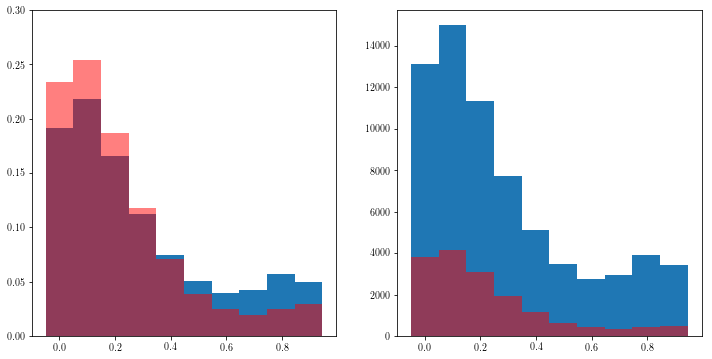

In [171]:
compare_kine('x', targ1_idx, targ1_and_diff_idx)

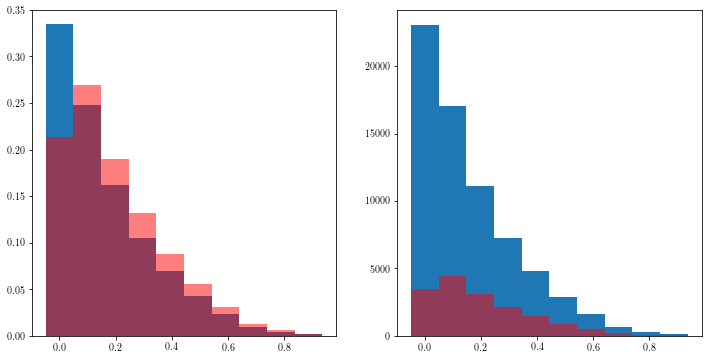

In [172]:
compare_kine('y', targ1_idx, targ1_and_diff_idx, ylim=0.35)

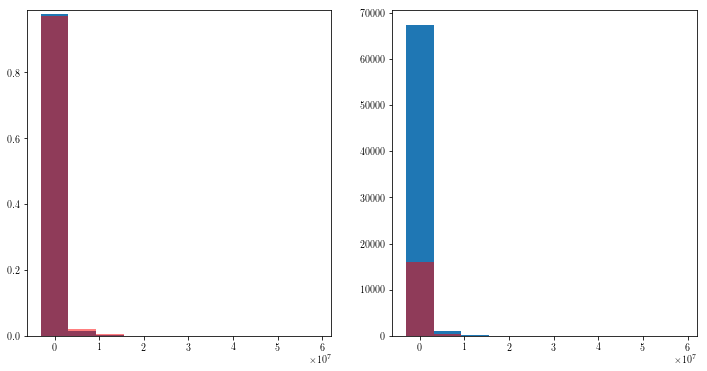

In [173]:
compare_kine('Q2', targ1_idx, targ1_and_diff_idx, ylim=0.99)

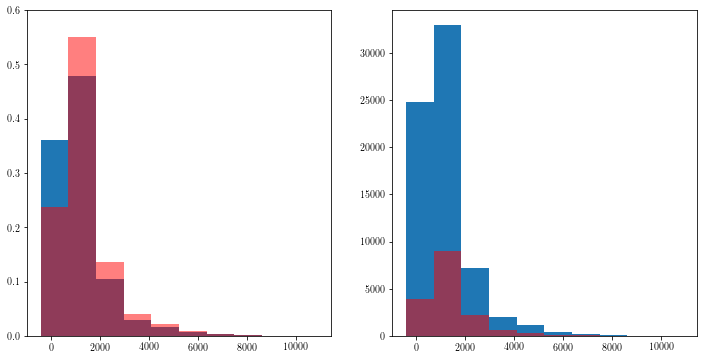

In [174]:
compare_kine('W', targ1_idx, targ1_and_diff_idx, ylim=0.6)

In [175]:
same_idx = df['planecode_natural'] == df['planecode_targbal']
diff_idx = df['planecode_natural'] != df['planecode_targbal']
same_idx &= targ1_idx
diff_idx &= targ1_idx
print(np.sum(same_idx))
print(np.sum(diff_idx))

52379
16408


In [176]:
def make_plane_assignment_indices(plane_type):
    targ1_upstrm_idx = df[plane_type] == 5
    targ1_upstrm_idx |= df[plane_type] == 6
    targ1_upstrm_idx |= df[plane_type] == 7
    targ1_upstrm_idx |= df[plane_type] == 8
    targ1_idx = df[plane_type] == 9
    targ1_dwnstrm_idx = df[plane_type] == 10
    targ1_dwnstrm_idx |= df[plane_type] == 11
    targ1_dwnstrm_idx |= df[plane_type] == 12
    targ1_dwnstrm_idx |= df[plane_type] == 13

    return targ1_upstrm_idx, targ1_idx, targ1_dwnstrm_idx

In [177]:
t1_true_up, t1_true, t1_true_down = make_plane_assignment_indices('true_plane')
t1_natl_up, t1_natl, t1_natl_down = make_plane_assignment_indices('planecode_natural')
t1_tbal_up, t1_tbal, t1_tbal_down = make_plane_assignment_indices('planecode_targbal')

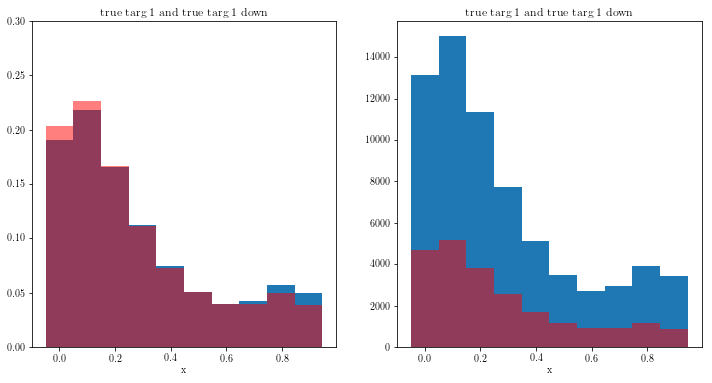

In [178]:
compare_kine('x', t1_true, t1_true_down, ptitle='true targ 1 and true targ 1 down', xtitle='x')

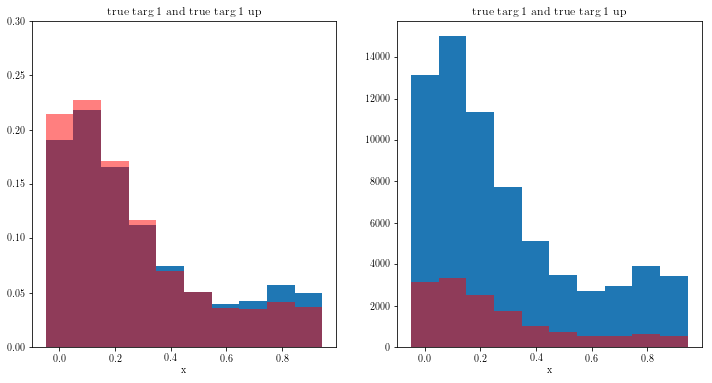

In [179]:
compare_kine('x', t1_true, t1_true_up, ptitle='true targ 1 and true targ 1 up', xtitle='x')

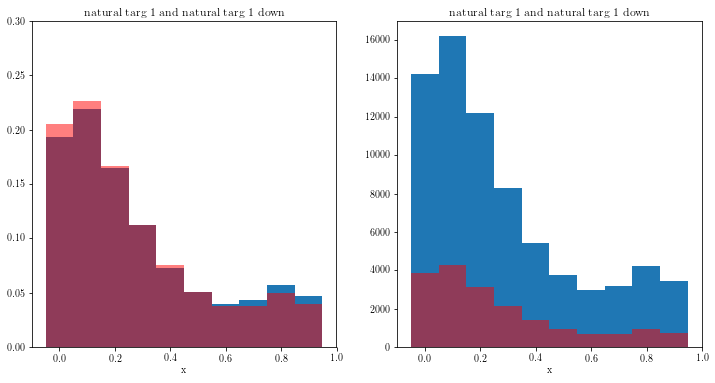

In [180]:
compare_kine('x', t1_natl, t1_natl_down, ptitle='natural targ 1 and natural targ 1 down', xtitle='x')

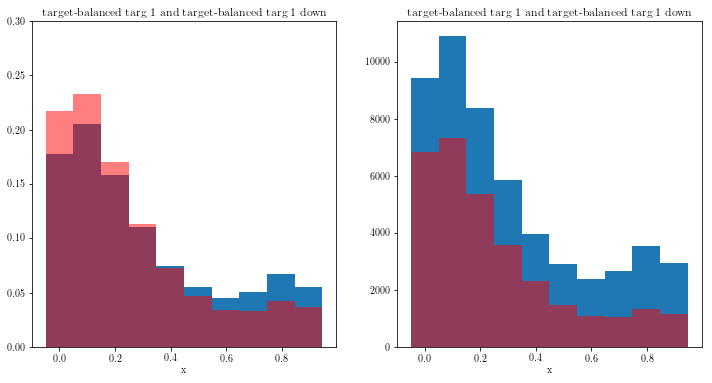

In [181]:
compare_kine('x', t1_tbal, t1_tbal_down, ptitle='target-balanced targ 1 and target-balanced targ 1 down', xtitle='x')

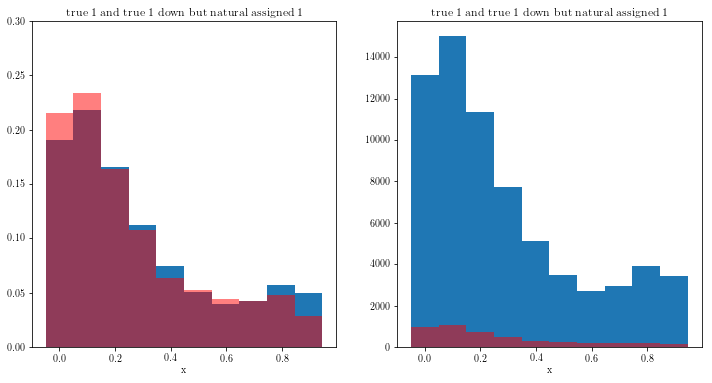

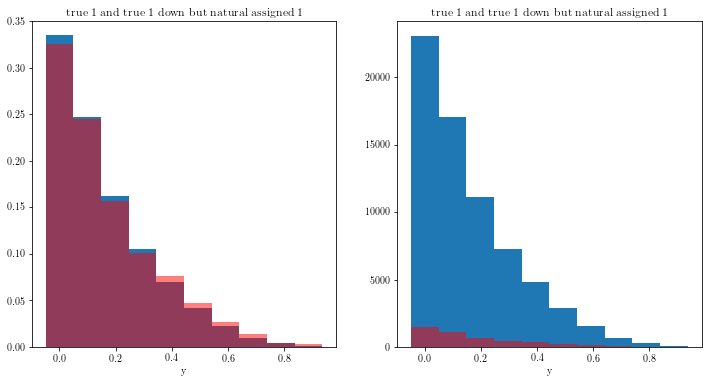

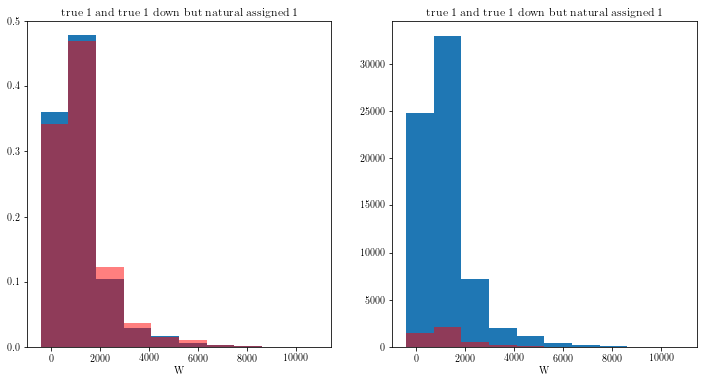

In [182]:
# compare t1_true_down but also t1_natl to t1_true
t1_true_down_and_t1_natl = t1_true_down & t1_natl
compare_kine('x', t1_true, t1_true_down_and_t1_natl, ptitle='true 1 and true 1 down but natural assigned 1', xtitle='x')
compare_kine('y', t1_true, t1_true_down_and_t1_natl, ylim=0.35, ptitle='true 1 and true 1 down but natural assigned 1', xtitle='y')
compare_kine('W', t1_true, t1_true_down_and_t1_natl, ylim=0.5, ptitle='true 1 and true 1 down but natural assigned 1', xtitle='W')

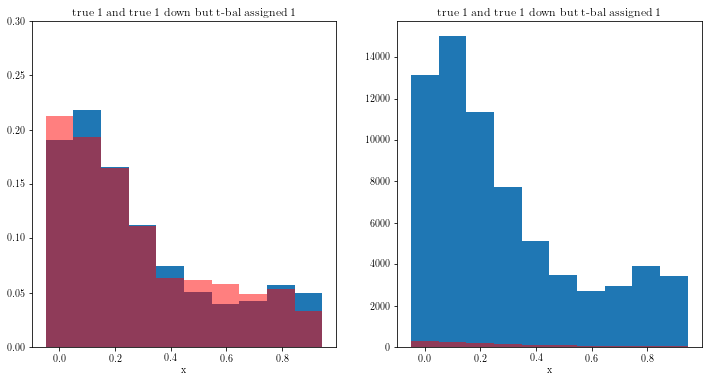

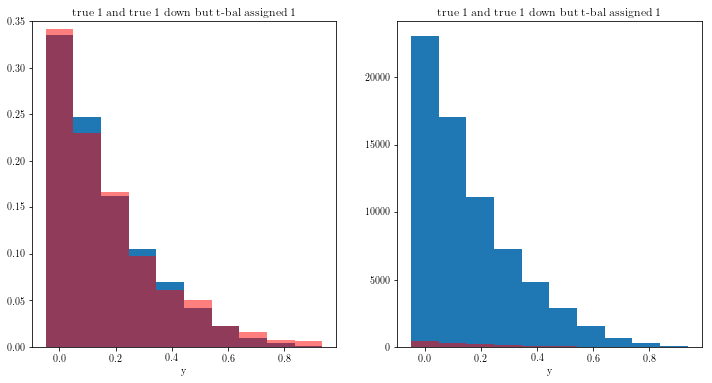

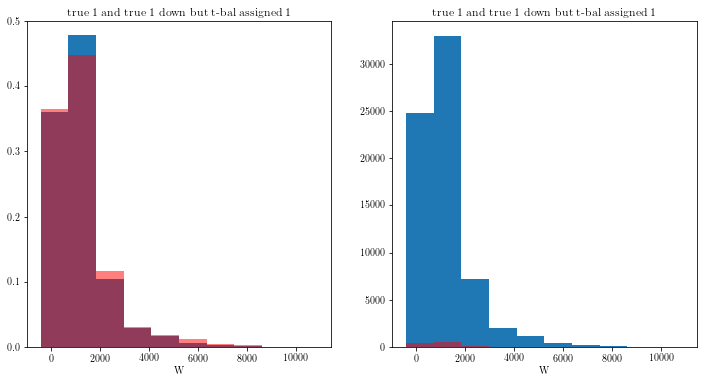

In [183]:
# compare t1_true_down but also t1_tbal to t1_true
t1_true_down_and_t1_tbal = t1_true_down & t1_tbal
compare_kine('x', t1_true, t1_true_down_and_t1_tbal, ptitle='true 1 and true 1 down but t-bal assigned 1', xtitle='x')
compare_kine('y', t1_true, t1_true_down_and_t1_tbal, ylim=0.35, ptitle='true 1 and true 1 down but t-bal assigned 1', xtitle='y')
compare_kine('W', t1_true, t1_true_down_and_t1_tbal, ylim=0.5, ptitle='true 1 and true 1 down but t-bal assigned 1', xtitle='W')